# Изменение цен в медицинской клинике - Исследовательский анализ данных

## Описание проекта

Проект представляет собой анализ данных медицинской клиники за период с 2021 по 2022 год. 
Цель проекта - определить ключевые драйверы изменения цен на лечение.

**Ход исследования**
Данные об исследовании находятся в файле data_test_task_2022.csv.
Для решения задачи я буду следовать следующему плану:
1. Проверю данные на полноту и корректность
2. Проверю качественные и количественные данные
3. Добавлю категорию услуг для анализа данных по этому срезу
4. Проверю изменение суммарной, средней и медианной цены
5. Сформулирую гипотезы
6. Проведу исследовательский анализ данных для проверки каждой гипотезы
7. Сформирую выводы на основе полученных данных

## Предобработка данных

Для начала загрузим все необходимые библиотеки

In [1]:
!pip install -q gdown

import pandas as pd
import gdown
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

Откроем датафрейм с данными

In [2]:
file_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vToHocA92nRmRntmTZBWnP1jZ0tx_x3fYAnaOdCXFPEffbtmbZkI_G1LgHb7eaZocBnwjuoHZ6PzlVu/pub?gid=1544566501&single=true&output=csv'

output_path = 'data_test_task_2022.csv'
gdown.download(file_url, output_path, quiet=True)

try:
    data = pd.read_csv(output_path)
except FileNotFoundError as e:
    print(f"Ошибка: {e}. Проверьте пути к файлам.")
except pd.errors.EmptyDataError:
    print("Ошибка: Один или несколько файлов пустые.")
except pd.errors.ParserError:
    print("Ошибка: Произошла ошибка при чтении данных. Проверьте формат файлов.")
except Exception as e:
    print(f"Произошла непредвиденная ошибка: {e}")
else:
    print("Файлы успешно прочитаны.")

C:\Users\vvakhrusheva\AppData\Local\anaconda3\Lib\site-packages\gdown\parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(


Файлы успешно прочитаны.


Теперь изучим содержание файла

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   record_id             85369 non-null  int64  
 1   service_date          85369 non-null  object 
 2   service_name          85369 non-null  object 
 3   service_amount        85369 non-null  int64  
 4   service_number        85369 non-null  int64  
 5   insured               85369 non-null  int64  
 6   sex_id                85348 non-null  float64
 7   age_for_service_date  85369 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 5.2+ MB


,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.0,26
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое иссл...",284,1,490777,2.0,26
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зев...",1134,1,490777,2.0,26
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.0,26
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.0,26


Файл содержит 7 столбцов:
1. record_id - уникальный идентификатор строки данных
2. service_date - дата оказания услуги
3. service_name - наименование услуги
4. service_amount - сумма выплат (стоимость оказанных услуг, руб.)
5. service_number - количество услуг
6. insured - уникальный идентификатор пациента
7. sex_id - пол пациента
8. age_for_service_date - возраст пациента на момент оказания услуги

Как видно из выгрузки данных о датасете, семь из восьми столбцов заполнены полностью, в sex_id отсутствует незначительное количество данных - 19 записей из 85 тысяч.

service_date - дата обращения, но хранится в типе данных object, заменим его на соответствующий данным тип datetime64.
Данные в sex_id приведем к целому числу.

In [4]:
data['service_date'] = pd.to_datetime(data['service_date'], format='%Y-%m-%d')
data['sex_id'] = data['sex_id'].replace('', pd.NA).astype(float).astype('Int64')


В остальном на этом уровне проверки данные не требуют изменений.

Перейдем к проверке дубликатов, содержания качественных данных и выбросов в количественных данных

### Проверка дубликатов

In [5]:
print('Полных дубликатов в данных:', data.duplicated().sum())
print('Дубликаты уникальных record_id:', data['record_id'].duplicated().sum())

Полных дубликатов в данных: 0
Дубликаты уникальных record_id: 0


Полных дубликатов в датафрейме нет как и дубликатов уникального идентификатора

### Проверка количественных данных

Проверим, какие даты охватывает датасет

In [6]:
print('Первая дата в датасете:', data['service_date'].min())
print('Последняя дата в датасете:', data['service_date'].max())
data['month'] = data['service_date'].dt.to_period('M')
print(data['month'].unique())

Первая дата в датасете: 2021-01-03 00:00:00
Последняя дата в датасете: 2022-08-31 00:00:00
<PeriodArray>
['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07',
 '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02',
 '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08']
Length: 20, dtype: period[M]


При сравнении данных по годам следуем учитывать, что данные за 2022 год неполные и охватывают только период с января по август. Отсутствием трех дней в начале января 2021 года можно пренебречь, так как эти дни скорее всего являлись выходными.

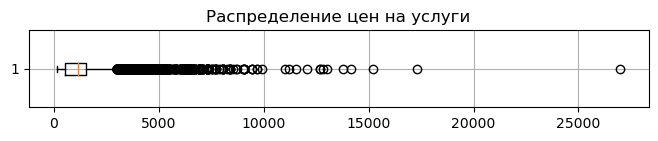

count    85369.000000
mean      1166.094636
std        799.062660
min        147.000000
25%        550.000000
50%       1155.000000
75%       1530.000000
max      26999.000000
Name: service_amount, dtype: float64

In [7]:
plt.figure(figsize=(8, 1))
plt.boxplot(data['service_amount'], vert=False) 
plt.title('Распределение цен на услуги')
plt.grid(True)
plt.show()
data['service_amount'].describe()

В ценах есть несколько выбросов с ценой выше 10 тысяч рублей, однако это могут быть дорогостоящие услуги, которые оказываются редко. 

In [8]:
filtered_amount = data[data['service_amount'] > 10000]
result_amount = pd.DataFrame({'service_name': filtered_amount['service_name'], 'service_amount': filtered_amount['service_amount']})
print(result_amount)

                                            service_name  service_amount
8316   МСКТ почек и надпочечников с внутривенным болю...           11025
15588  МРТ брюшной полости и забрюшинного пространств...           17325
16373  МСКТ мочевыделительной системы с внутривенным ...           12075
16564            Вскрытие абсцесса различной локализации           12810
18518  Тотальная внутривенная анестезия от 20 минут д...           11550
18519             гистерорезектоскопия при полипах , РДВ           26999
23794  МРТ головного мозга и гипофиза с контрастирова...           15225
27994  Мультипараметрическая МРТ предстательной желез...           14175
36348  МСКТ органов брюшной полости и забрюшинного пр...           12680
36760  МСКТ органов брюшной полости и забрюшинного пр...           12680
37286  МРТ органов малого таза с внутривенным контрас...           13780
83450                              МРТ коленного сустава           13000
83457                  Вскрытие абсцедирующего фуру

Так и есть: эти услуги являются дорогостоящими, и, вероятно, оказываются нечасто в данной клиникеservice_number

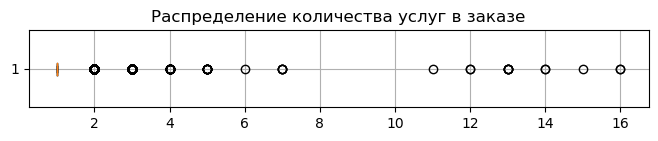

count    85369.000000
mean         1.022865
std          0.229015
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: service_number, dtype: float64

In [9]:
plt.figure(figsize=(8, 1))
plt.boxplot(data['service_number'], vert=False) 
plt.title('Распределение количества услуг в заказе')
plt.grid(True)
plt.show()
data['service_number'].describe()

Абсолютное большинство пациентов получало одну услугу за раз, при этом несколько пациентов получили большое количество одинаковых услуг - до 16 - за одно посещение

In [10]:
filtered_number = data[data['service_number'] > 3]
result_number = pd.DataFrame({'service_name': filtered_number['service_name'], 'service_number': filtered_number['service_number']})
result_number = result_number.sort_values(by='service_number')
print(result_number)

                                            service_name  service_number
1336                                        Взятие мазка               4
42884                  Перевязка чистая (менее 4 кв.см.)               4
42877                  Перевязка чистая (менее 4 кв.см.)               4
42874                      Снятие швов, одна локализация               4
42873                  Перевязка чистая (менее 4 кв.см.)               4
42871                  Перевязка чистая (менее 4 кв.см.)               4
80414                Ультразвуковое исследование сустава               4
51575                                       Взятие мазка               4
80415         Рентгенография крупного сустава (2 снимка)               4
71450                  Перевязка чистая (менее 4 кв.см.)               4
31909                                       Взятие мазка               4
29264                Ультразвуковое исследование сустава               4
27860                                       Взятие 

Большая часть таких услуг - перевязки, мазки и постановка аллергопроб, которые действительно требуют нескольких повторений

<Axes: >

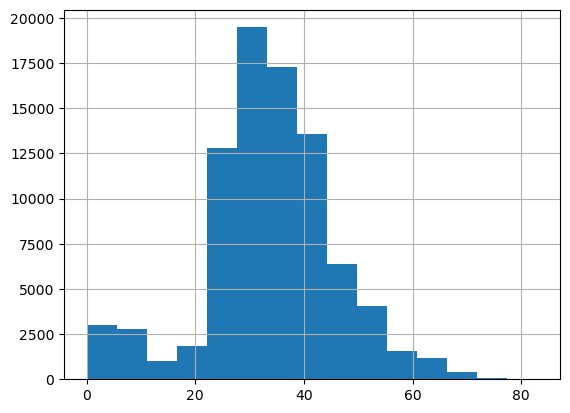

In [11]:
data['age_for_service_date'].hist(bins=15)

В распределении пациентов по возрастам все выглядит корректно: по большей часть обращаются люди в районе 30

### Проверка качественных данных

Название услуги - единственный маркер, по которому возможно категоризировать услуги.
Посчитаем, сколько уникальных названий содержит датафрейм и посмотрим на пример этих данных

In [12]:
count_unique_values = len(data['service_name'].unique())
print("Количество уникальных значений:", count_unique_values)
print()
print(data['service_name'].unique()[:100])

Количество уникальных значений: 875

['Прием первичный'
 'Взятие материала на посев, цитологическое исследование ( риноцитограмма)'
 'Посев отдел, дыхательных путей - слизистая зева с определением чувствительности к антибиотикам'
 'Общий анализ крови (лейкоцитарная форм,, СОЭ)' 'Ревматоидный фактор'
 'С-реактивный белок' 'Взятие крови из периферической вены'
 'Магнитотерапия (1 сеанс)' 'УВЧ-терапия (1 сеанс) (1 поле)'
 'Прием повторный' 'Смазывание глотки лекарственными формами'
 'Взятие мазка' 'Обработка вульвы' 'Обработка шейки матки'
 'Гинекологический мазок' 'Общий анализ мочи' 'Креатинин'
 'Мочевая кислота' 'Мочевина' 'Общий белок'
 'Ультразвуковое исследование почек и надпочечников'
 'Ультразвуковое исследование мочевого пузыря'
 'ЛПНП (липопротеиды низкой плотности, бета-липопротеиды)' 'Триглицериды'
 'Холестерин' 'АЛТ (аланинаминотрансфераза)' 'Альдостерон'
 'Кортизол (кровь)' 'Ренин + Ангиотензин 1' 'Т4 св' 'ТТГ (тиреотропин)'
 'АСТ (аспартатаминотрансфераза)' 'Билирубин общий

Стоблец содержит 875 уникальных названий - категоризировать данные на таком объеме сложно. Но на примере части этих названий видно, что можно разделить их на несколько крупных категорий: УЗИ, анализы (кровь, посев и т.д.), массаж, прием врача и т.д.

Приведем все наименования к нижнему регистру, а затем напишем функцию для категоризации услуг

In [13]:
data['service_name'] = data['service_name'].str.lower()

classification_dict = {
    'узи': ['узи', 'ультразвуковое'],
    'анализы': ['мазок', 'кров', 'соскоб', 'посев', 'мазка', 'анализ', 'моч', 'кал', 'белок', 'витамин', 'ревмато', 'креатинин', 
                'липо', 'триглицерид', 'холестерин', 'алт', 'билирубин', 'ферр', 'секрет', 'пса', 'проб', 'гормон', 'антител', 'ттг',
               'herpes', 'igg', 'igm', 'герпес', 'вирус', 'пролактин', 'ренин', 'желез', 'кислота', 'iga', 'гепатит', 'антиген', 'hpv', 'igм',
               'ат к', 'т3', 'т4', 'кортизол', 'инсулин','милаза','бактер', 'фераза', 'альдостерон', 'фосфотаза', 'соэ', 'rh-фактор',
               'фосфор', 'магний', 'гемоглобин', 'лейкоцит', 'фибриноген', 'тромб', 'натрий', 'серотонин', 'цинк', 'асло', 'цистеин', 'альбумин', 'слюна',
               'пептид', 'рфмк', 'липаза', 'эстрадиол', 'глобулин', 'креатинкиназа', 'сифилис', 'лдг', 'д-димер', 'холинэстераза', 'сульфат', 
                'протеин', 'ретикулоциты', 'келл', 'фракции', 'андростендион'],
    'прием врача': ['прием', 'осмотр', 'консульт'],
    'исследование': ['исследование', 'измерение', 'сканирование', 'монитор', 'экг', 'тест', 'скопи', 'графи', 'ээг', 'мрт', 'мскт', 'исслед'],
    'физиотерапия': ['терапи', 'токи', 'форез', 'сеанс', 'электро'],
    'массаж': ['массаж'],
    'раневая обработка': ['перевяз', 'швов', 'шва', 'компресс', 'повяз'],
    'акушерство и гинекология': ['матк', 'вульв', 'влагалищ', 'скриннинг', 'акушер', 'впч', 'скрининг', 'хгч', 'прогестерон'],
    'хирургия': ['удален', 'вскрыти', 'пункци', 'хирург', 'деструкц', 'шинирован'],
    'рентген': ['рентген'], 
    'вакцинация': ['вакцин'], 
    'пребывание в стационаре': ['стационар'], 
    'лор': ['глотк', 'носа', 'дыхан', 'лор', 'нос', 'ухо', 'слух', 'слез', 'глаз', 'синусит', 'ресни', 'миндалин', 'ингаляци', 'рино'],
    'офтальмолог': ['очков', 'конъюнк', 'метрия'],
    'инъекции': ['инъекция', 'блокада', 'внутримыш'],
    'урология': ['уретр'],
    'лфк': ['лфк'],
    'аллергические исследования': ['аллер', 'эпител', 'таракан', 'ige', 'плесень', 'клещ', 'пыльца', 'попуга', 'латекс'], 
    'анестезия': ['анестез']
}

def categorize_name(row):
    service = row['service_name']
    
    for category, substrings in classification_dict.items():
        for substring in substrings:
            if substring in service:
                return category
    
    return 'прочее'


data['service_category'] = data.apply(categorize_name, axis=1)

Распределив большую часть услуг мы получили 19 категорий. Большая часть услуг относится к категориям анализов, приемам врачей, физиотерамии и исследованиями

In [14]:
category_counts = data['service_category'].value_counts()
category_counts_df = pd.DataFrame({'Service Category': category_counts.index, 'Count': category_counts.values})
print(category_counts_df)

              Service Category  Count
0                      анализы  28038
1                  прием врача  26628
2                 физиотерапия   9513
3                 исследование   9232
4                          узи   4526
5                  офтальмолог   1864
6                       массаж   1727
7                          лор   1308
8            раневая обработка    783
9                     инъекции    423
10                      прочее    265
11  аллергические исследования    258
12    акушерство и гинекология    244
13                   анестезия    228
14                    хирургия    186
15                    урология    100
16                  вакцинация     29
17                         лфк     15
18     пребывание в стационаре      2


Теперь можно приступать к анализу данных

## Анализ данных

Для начала построим график изменения цен в клинике по месяцам за весь период наличия данных и по годам, оставив равные периоды

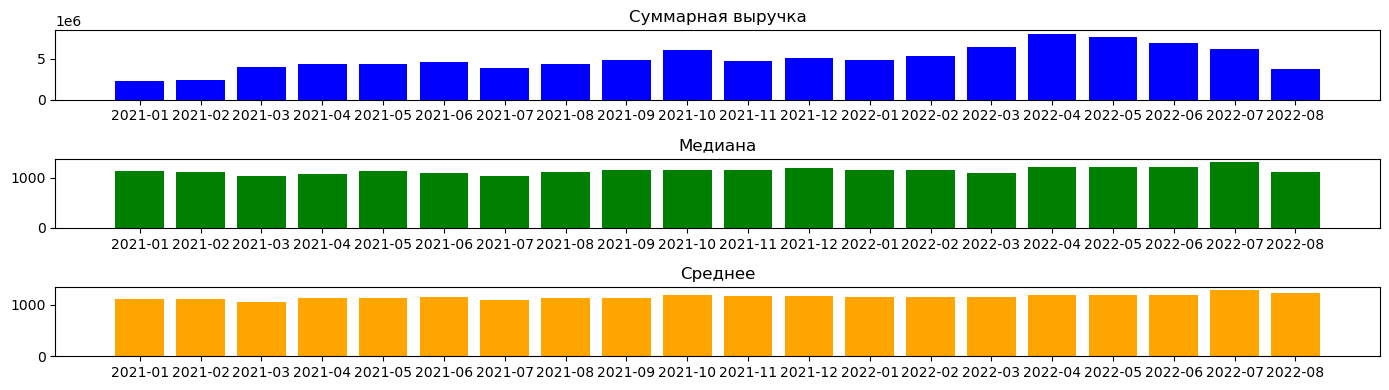

<Figure size 640x480 with 0 Axes>

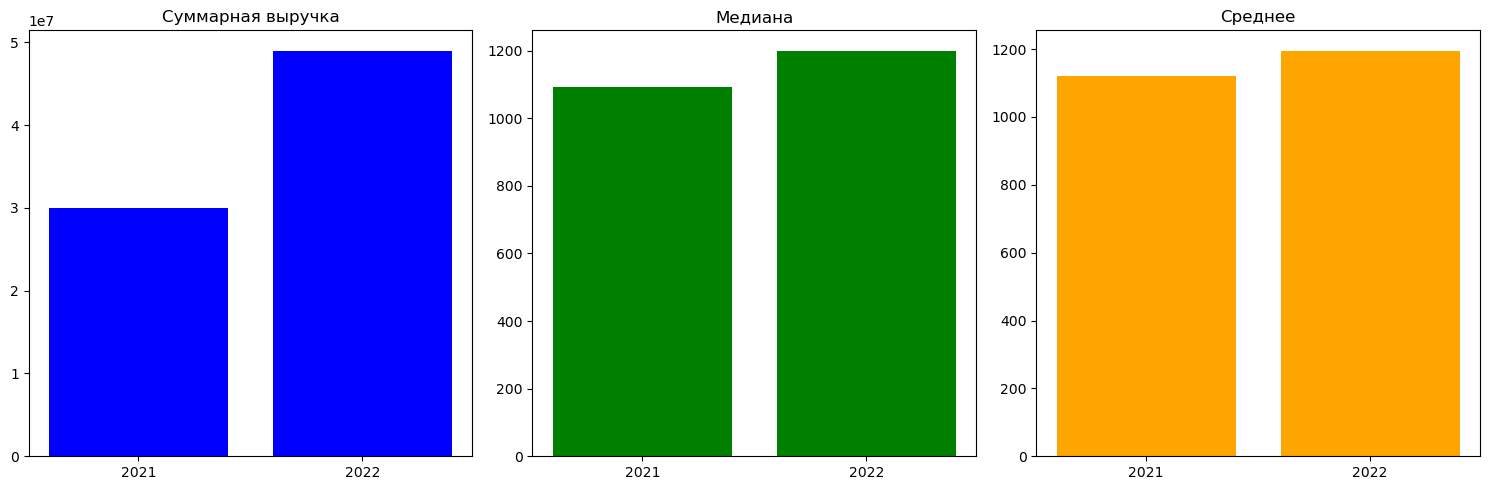

In [15]:
#сравним данные по месяцам
grouped_data_m = data.groupby('month')

result_m = grouped_data_m.agg({
    'service_amount': ['sum', 'median', 'mean']
}).reset_index()
result_m = result_m.round(2)

fig, axes = plt.subplots(3, 1, figsize=(14, 4))

# Суммарные показатели
axes[0].bar(result_m['month'].astype(str), result_m['service_amount']['sum'], color='blue')
axes[0].set_title('Суммарная выручка')

# Медиана
axes[1].bar(result_m['month'].astype(str), result_m['service_amount']['median'], color='green')
axes[1].set_title('Медиана')

# Среднее
axes[2].bar(result_m['month'].astype(str), result_m['service_amount']['mean'], color='orange')
axes[2].set_title('Среднее')
plt.tight_layout()
plt.show()

#сравним данные по годам за период с января по август
data['year'] = data['service_date'].dt.to_period('Y')
equal_y_periods = data[(data['service_date'].dt.month <= 8)]
grouped_data_y = equal_y_periods.groupby('year')

result_y = grouped_data_y.agg({
    'service_amount': ['sum', 'median', 'mean']
}).reset_index()
result_y = result_y.round(2)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

# Суммарные показатели
axes[0].bar(result_y['year'].astype(str), result_y['service_amount']['sum'], color='blue')
axes[0].set_title('Суммарная выручка')

# Медиана
axes[1].bar(result_y['year'].astype(str), result_y['service_amount']['median'], color='green')
axes[1].set_title('Медиана')

# Среднее
axes[2].bar(result_y['year'].astype(str), result_y['service_amount']['mean'], color='orange')
axes[2].set_title('Среднее')

plt.tight_layout()
plt.show()

In [195]:
result_y['sum_percent_change'] = round(result_y['service_amount', 'sum'].pct_change() * 100, 2)
result_y['median_percent_change'] = round(result_y['service_amount', 'median'].pct_change() * 100, 2)
result_y['mean_percent_change'] = round(result_y['service_amount', 'mean'].pct_change() * 100, 2)

change_2022 = result_y[result_y['year'] == '2022'][['sum_percent_change', 'median_percent_change', 'mean_percent_change']]

print('Изменение суммы выручки, %:', change_2022['sum_percent_change'].values[0])
print('Изменение медианы оплаты, %:', change_2022['median_percent_change'].values[0])
print('Изменение средней оплаты, %:', change_2022['mean_percent_change'].values[0])

Изменение суммы выручки, %: 63.52
Изменение медианы оплаты, %: 9.89
Изменение средней оплаты, %: 6.69


В помесячном сравнении не видно значительных колебаний средних и медианных показателей, но на графике суммарной вырчуки виден рост с февраля с последующим снижением.
В сравнении периодов с января по август по годам видно, что суммарная выручка за этот период выросла сильнее, чем медианные и средние значения. Это значит, что кроме роста цены на услуги также выросло их количество.

Говоря о средней стоимости посещения медицинской клиники в сравнении по годам, нельзя не учитывать инфляцию.
Согласно данным на https://rosstat.gov.ru/statistics/price в разделе "Средние потребительские цены" в файле "Средние потребительские цены на отдельные виды товаров и услуг по Российской Федерации (в 1991-2023 гг.)", средняя стоимость консультации у врача в 2021 году составляла 889 рублей, а в 2022 - 1028 рублей. 
Других категорий медицинских услуг в файле не представлено, поэтому возьмем эти данные за среднее по всем услугам.
Кроме того, важно учитывать, что регион, в котором находится клиника, также неизвестен.

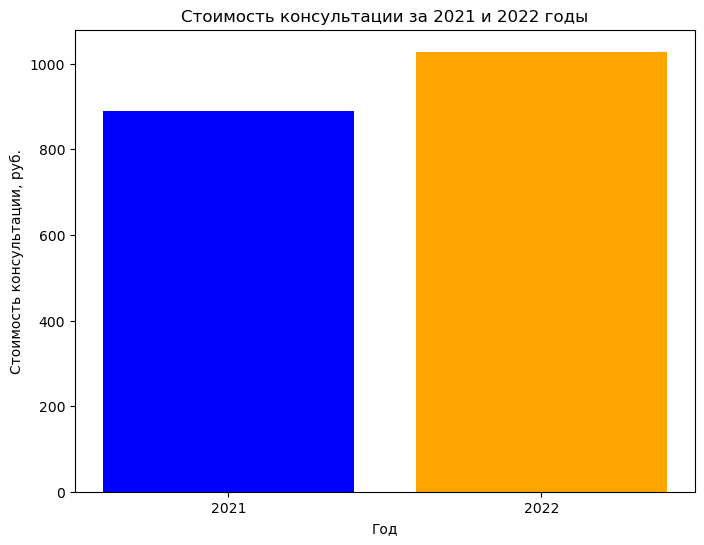

Процент инфляции за период 2021-2022 годов: 15.64%


In [192]:
consultation_costs = {'2021': 889, '2022': 1028}

years = list(consultation_costs.keys())
costs = list(consultation_costs.values())
plt.figure(figsize=(8, 6))
plt.bar(years, costs, color=['blue', 'orange'])
plt.xlabel('Год')
plt.ylabel('Стоимость консультации, руб.')
plt.title('Стоимость консультации за 2021 и 2022 годы')
plt.show()

inflation_percentage = ((consultation_costs['2022'] - consultation_costs['2021']) / consultation_costs['2021']) * 100

print(f"Процент инфляции за период 2021-2022 годов: {inflation_percentage:.2f}%")

Так как данные за 2022 год есть только по август, посчитаем процент инфляции к концу августа

In [199]:
months_until_august = 8
inflation_until_august_2022 = (inflation_percentage / 12) * 8

print(f"Процент инфляции к концу августа 2022 года: {inflation_until_august_2022:.2f}%")

Процент инфляции к концу августа 2022 года: 10.42%


Средняя инфляция составила 10,42%, что выше, чем рост средней цены в клинике. Это может быть обусловлено более низкой ценой по сравнению с ценами клиники, но в любом случае стоит отметить, что рост цен в клинике находится ниже уровня инфляции. 

Также посмотрим на общее изменение количество записей по месяцам и годам

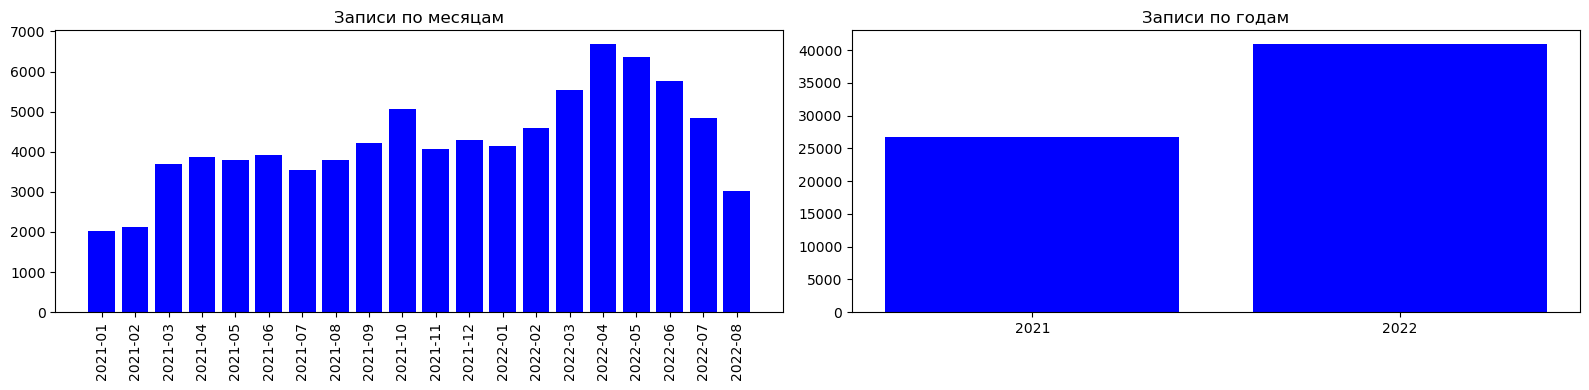

Изменение количества записей, %: 53.27


In [198]:
grouped_data_m = data.groupby('month')

result_r_m = grouped_data_m.agg({
    'record_id': 'count'
}).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].bar(result_r_m['month'].astype(str), result_r_m['record_id'], color='blue')
axes[0].set_title('Записи по месяцам')
axes[0].tick_params(axis='x', rotation=90)

result_r_y = grouped_data_y.agg({
    'record_id': 'count'
}).reset_index()

axes[1].bar(result_r_y['year'].astype(str), result_r_y['record_id'], color='blue')
axes[1].set_title('Записи по годам')
plt.tight_layout()
plt.show()

result_r_y['percent_change'] = round(result_r_y['record_id'].pct_change() * 100, 2)
change_r_2022 = result_r_y[result_r_y['year'] == '2022']['percent_change']

print('Изменение количества записей, %:', change_r_2022.values[0])

Количество записей заметно выросло в апреле 2022, что совпадает с ростом выручки на графиках выше.
Общий прирост количества записей в январе-августе вырос на 53%. 
Это коррелирует с ростом выручки и среднего чека в эти же периоды.

### Гипотезы

На основе предварительного первичного анализа данных мы можем сформулировать несколько гипотез для дальнейшей проверки:
1. В 2022 году состав услуг изменился в сторону увеличения доли более дорогих услуг
2. В 2022 году изменился портрет пользователей, что привело к изменению стоимости услуг

Далее поочередно проверим эти гипотезы, чтобы подтвердить или опровергнуть их

#### 1. К росту цен привело изменение состава услуг

 Изучим динамику изменения количества записей по категориям услуг

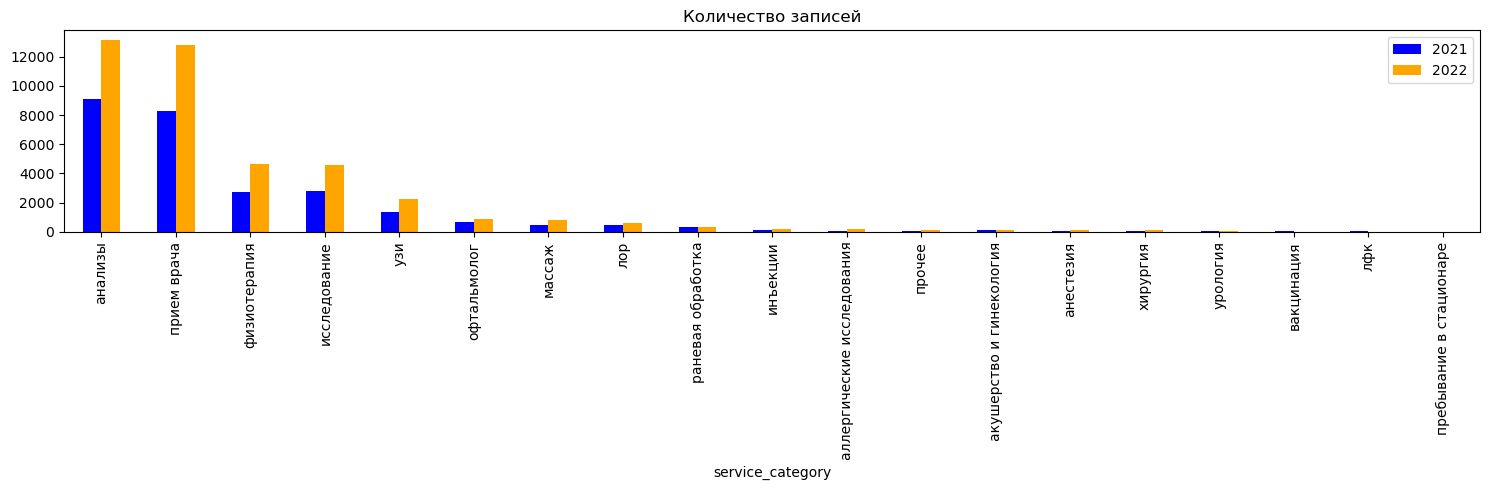

,Изменение в абсолютах,Изменение в процентах,Количество записей
service_category,,,
анализы,4054.0,44.53,28038
прием врача,4532.0,54.63,26628
физиотерапия,1888.0,68.93,9513
исследование,1755.0,62.26,9232
узи,904.0,66.32,4526
офтальмолог,240.0,37.91,1864
массаж,367.0,78.92,1727
лор,109.0,23.29,1308
раневая обработка,28.0,9.33,783


In [24]:
grouped_data_c = equal_y_periods.groupby(['year', 'service_category'])
result_rec = grouped_data_c.agg({
    'record_id': 'count'
}).reset_index()
pivot_result_rec = result_rec.pivot_table(index='service_category', columns=['year'], values='record_id')
pivot_result_rec.columns = ['2021', '2022']

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
pivot_result_rec_sorted = pivot_result_rec.sort_values(by='2022', ascending=False)
pivot_result_rec_sorted.plot(kind='bar', ax=axes, color=['blue', 'orange'])
axes.set_title('Количество записей')
plt.tight_layout()
plt.show()

pivot_result_rec['Изменение в абсолютах'] = (pivot_result_rec['2022'] - pivot_result_rec['2021'])
pivot_result_rec['Изменение в процентах'] = round((pivot_result_rec['Изменение в абсолютах'] / pivot_result_rec['2021']) * 100, 2)
pivot_result_rec['Количество записей'] = data.groupby('service_category')['record_id'].nunique()
pivot_result_rec_sorted = pivot_result_rec.sort_values(by='Количество записей', ascending=False)

pivot_result_rec_sorted[['Изменение в абсолютах', 'Изменение в процентах', 'Количество записей']]


Средний прирост количества записей составил 53%, при этом самая многочисленная и недорогая категория "Анализы" выросла на 44%.
Сильнее всего в процентном соотношении выросло количество записей в категориях, где объем не превышает 10% от общего, что не могло повлиять на общие показатели.

Посмотрим на изменение доли категорий год к году

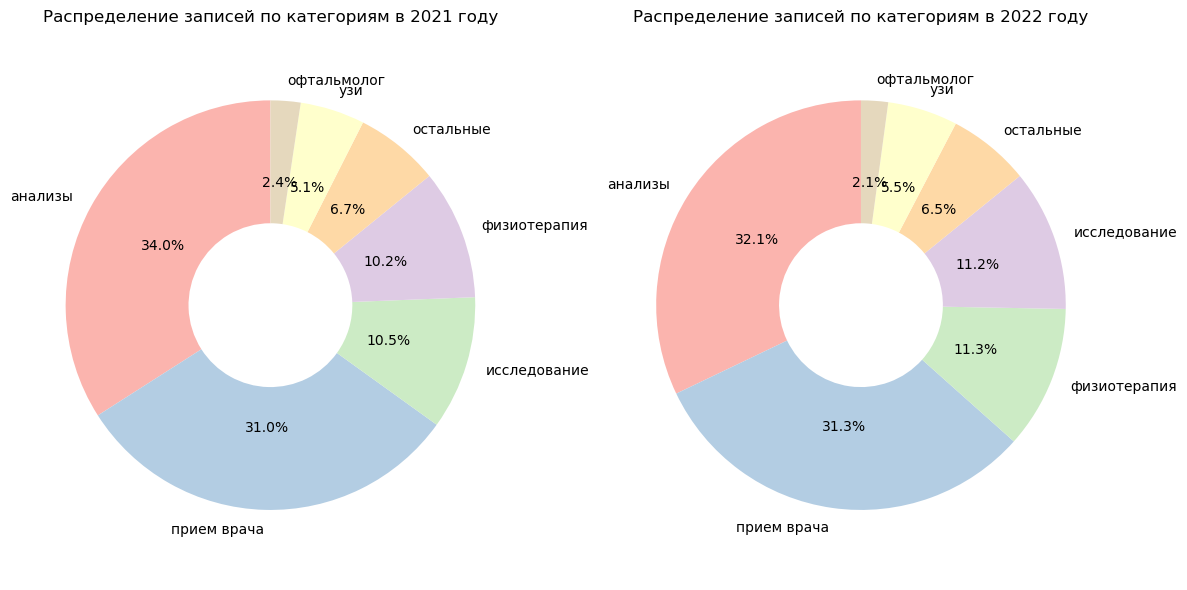

In [31]:
# Заменим NaN на 0, чтобы построить графики
pivot_result_rec.fillna(0, inplace=True)

pivot_result_rec = pivot_result_rec.reset_index()

pivot_result_rec['service_category'] = pivot_result_rec['service_category'].astype(str)

# Отберем топ-6 категорий и перенесем остальное в "остальные", чтобы графики не "шумели"
top_categories_2021 = pivot_result_rec.nlargest(6, '2021')['service_category']
top_categories_2022 = pivot_result_rec.nlargest(6, '2022')['service_category']

pivot_result_rec['category_combined_2021'] = pivot_result_rec['service_category'].where(
    pivot_result_rec['service_category'].isin(top_categories_2021), 'остальные'
)
pivot_result_rec['category_combined_2022'] = pivot_result_rec['service_category'].where(
    pivot_result_rec['service_category'].isin(top_categories_2022), 'остальные'
)
grouped_data_combined_2021 = pivot_result_rec.groupby('category_combined_2021').sum()
grouped_data_combined_2022 = pivot_result_rec.groupby('category_combined_2022').sum()

data_combined_2021 = grouped_data_combined_2021[['2021']].reset_index().sort_values(by='2021', ascending=False)
labels_combined_2021 = data_combined_2021['category_combined_2021']
sizes_combined_2021 = data_combined_2021['2021']

data_combined_2022 = grouped_data_combined_2022[['2022']].reset_index().sort_values(by='2022', ascending=False)
labels_combined_2022 = data_combined_2022['category_combined_2022']
sizes_combined_2022 = data_combined_2022['2022']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(sizes_combined_2021, labels=labels_combined_2021, autopct='%1.1f%%', startangle=90,
            wedgeprops=dict(width=0.6), colors=plt.cm.Pastel1.colors)
axes[0].axis('equal')
axes[0].set_title('Распределение записей по категориям в 2021 году')

axes[1].pie(sizes_combined_2022, labels=labels_combined_2022, autopct='%1.1f%%', startangle=90,
            wedgeprops=dict(width=0.6), colors=plt.cm.Pastel1.colors)
axes[1].axis('equal')
axes[1].set_title('Распределение записей по категориям в 2022 году')

plt.tight_layout()
plt.show()


Распределение записей по категориям почти не изменилось: виден прирост на 1 п.п. в категориях исследований и физиотерапии, и снижение на 2 п.п. в самой объемной категории анализов, однако состав топовых категорий и их расположение значительно не изменились.

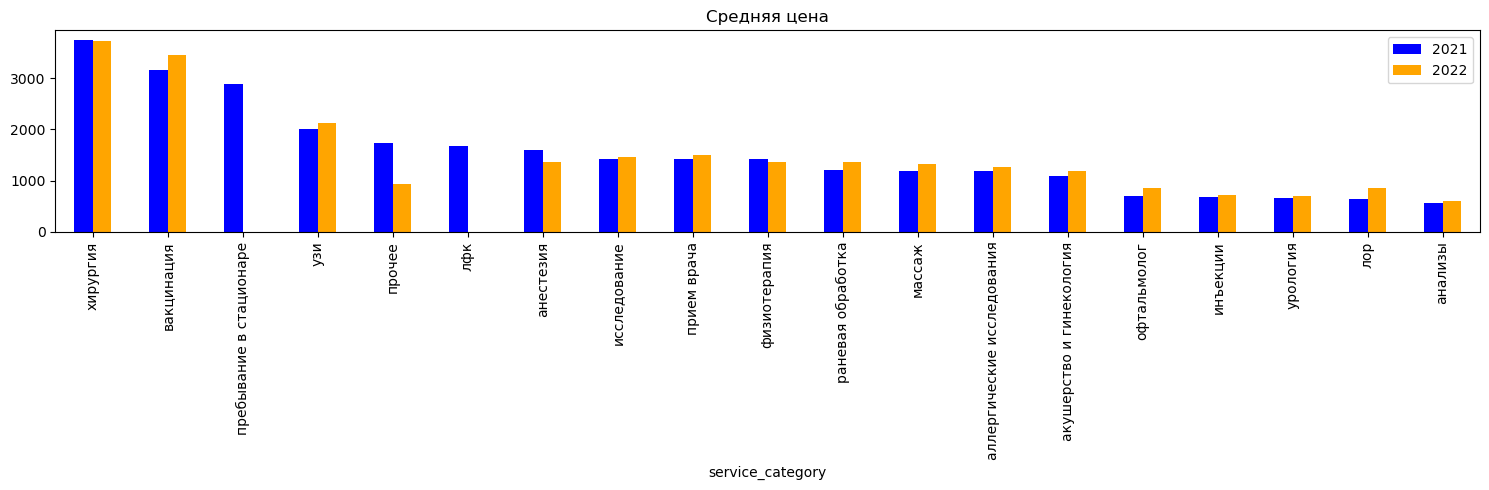

,Изменение в абсолютах,Изменение в процентах,Средняя цена
service_category,,,
хирургия,-26.98,-0.72,3638.97
вакцинация,278.59,8.80,3198.59
пребывание в стационаре,NaN,NaN,2888.00
узи,122.46,6.12,2075.50
лфк,NaN,NaN,1680.00
прием врача,94.02,6.64,1471.22
анестезия,-224.18,-14.10,1454.01
исследование,42.60,3.00,1446.85
физиотерапия,-49.17,-3.48,1395.38


In [74]:
#соберем данные по средней цене внутри каждой категории
result_price = grouped_data_c.agg({
    'service_amount': 'mean'
}).reset_index()
pivot_result_price = result_price.pivot_table(index='service_category', columns=['year'], values='service_amount')
pivot_result_price.columns = ['2021', '2022']

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
pivot_result_price_sorted = pivot_result_price.sort_values(by='2021', ascending=False)
pivot_result_price_sorted.plot(kind='bar', ax=axes, color=['blue', 'orange'])
axes.set_title('Средняя цена')
plt.tight_layout()
plt.show()

pivot_result_price['Изменение в абсолютах'] = round(pivot_result_price['2022'] - pivot_result_price['2021'], 2)
pivot_result_price['Изменение в процентах'] = round((pivot_result_price['Изменение в абсолютах'] / pivot_result_price['2021']) * 100, 2)
pivot_result_price['Средняя цена'] = round(data.groupby('service_category')['service_amount'].mean(), 2)
pivot_result_price_sorted = pivot_result_price.sort_values(by='Средняя цена', ascending=False)

pivot_result_price_sorted[['Изменение в абсолютах', 'Изменение в процентах', 'Средняя цена']]

Средняя цена выросла почти во всех категориях, в частности в двух наиболее объемных категориях - анализах и приеме врача.
Значительно снизилась средняя цена в "прочем", но так как эта категория состоит из не вошедших в другие категории услуг, это может говорить об изменении их перечня. 
Выше вровня инфляции выросла стоимость услуг двух профильных специалистов: лора и офтальмолога

Причина роста цен - не изменение состава услуг: соотношение категорий не изменилось, средняя цена выросла почти везде.
**Гипотеза опровергнута.**

#### 2. К росту цен привело изменение портрета пользователей

Чтобы изучить данные в рамках этой гипотезы, посмотрим на изменение выручки и среднего чека в двух срезах - пол и возраст.
Для этого разделим пользователей на несколько возрастных категорий на основе данных столбца age_for_service_date

In [44]:
bins = [0, 17, 23, 40, 55, float('inf')]  
labels = ['0-17', '18-23', '24-39', '40-55', '56+'] 
data['age_group'] = pd.cut(data['age_for_service_date'], bins=bins, labels=labels, right=False)

data.groupby('age_group')['insured'].nunique()

age_group
0-17      543
18-23     136
24-39    2787
40-55     901
56+       171
Name: insured, dtype: int64

Теперь изучим изменение соотношения возрастных групп по годам и средней стоимости записи в них

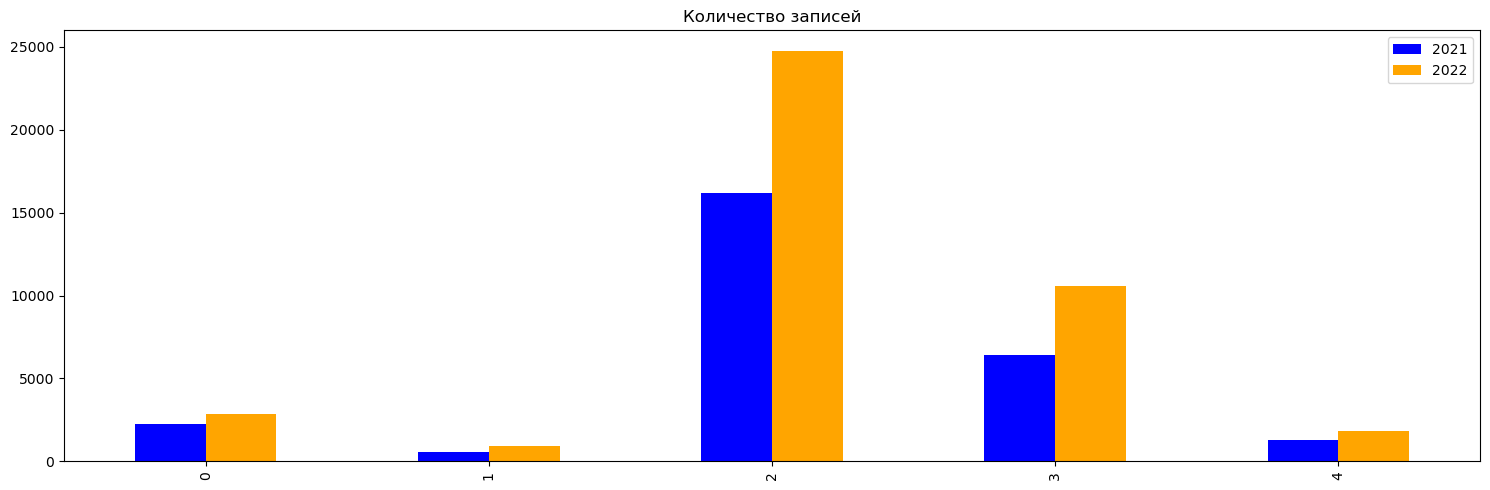

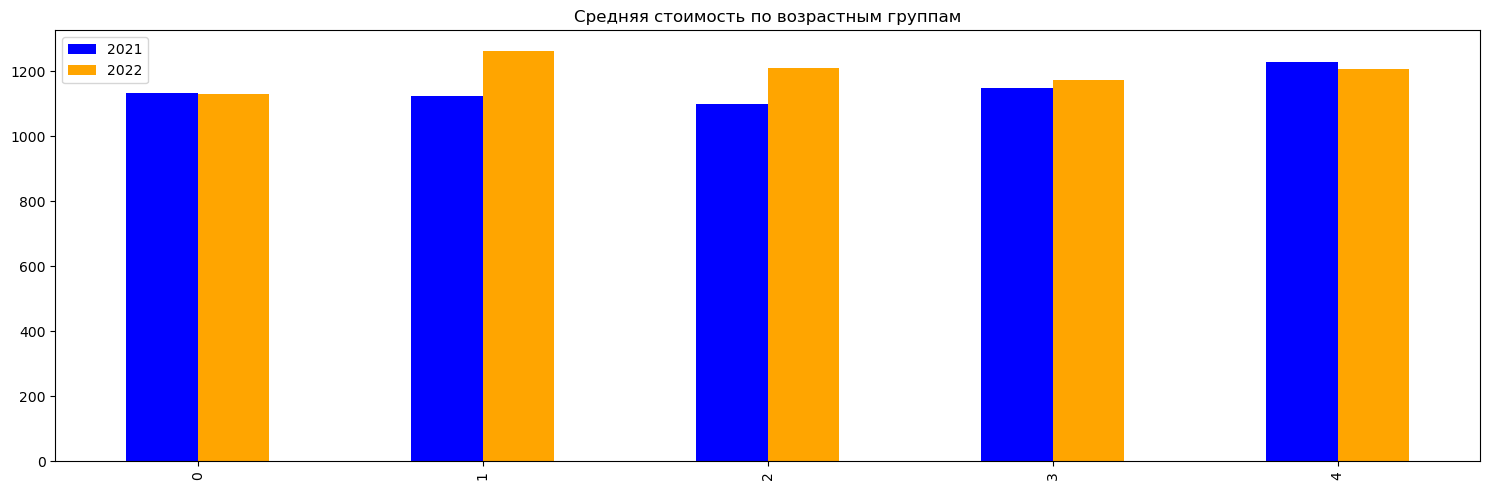

In [206]:
equal_y_periods = data[(data['service_date'].dt.month <= 8)]
grouped_data_age = equal_y_periods.groupby(['year', 'age_group'])

result_age = grouped_data_age.agg({
    'insured': 'count'
}).reset_index()
pivot_result_age = result_age.pivot_table(index='age_group', columns=['year'], values='insured')
pivot_result_age.columns = ['2021', '2022']
pivot_result_age = pivot_result_age.reset_index()

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
pivot_result_age.plot(kind='bar', ax=axes, color=['blue', 'orange'])
axes.set_title('Количество записей')
plt.tight_layout()
plt.show()

result_age_p = grouped_data_age.agg({
    'service_amount': 'mean'
}).reset_index()
pivot_result_age_p = result_age_p.pivot_table(index='age_group', columns=['year'], values='service_amount')
pivot_result_age_p.columns = ['2021', '2022']
pivot_result_age_p = pivot_result_age_p.reset_index()

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
pivot_result_age_p.plot(kind='bar', ax=axes, color=['blue', 'orange'])
axes.set_title('Средняя стоимость по возрастным группам')
plt.tight_layout()
plt.show()

В основных возрастных категориях - 24-40 и 40-55, рассмотрим распределение по категориям

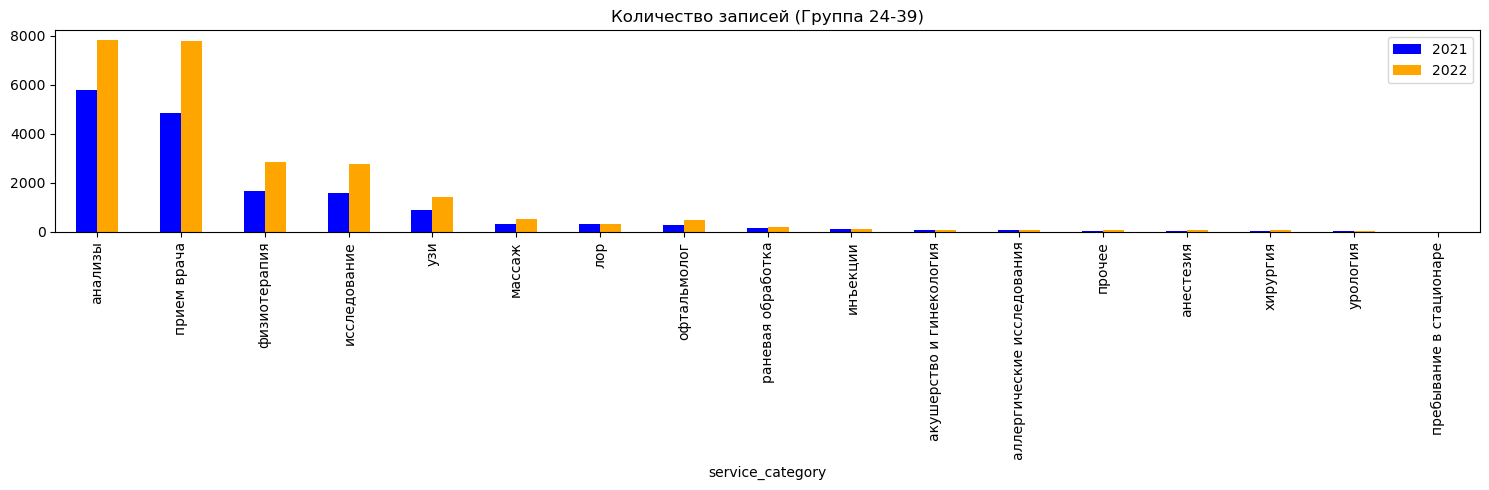

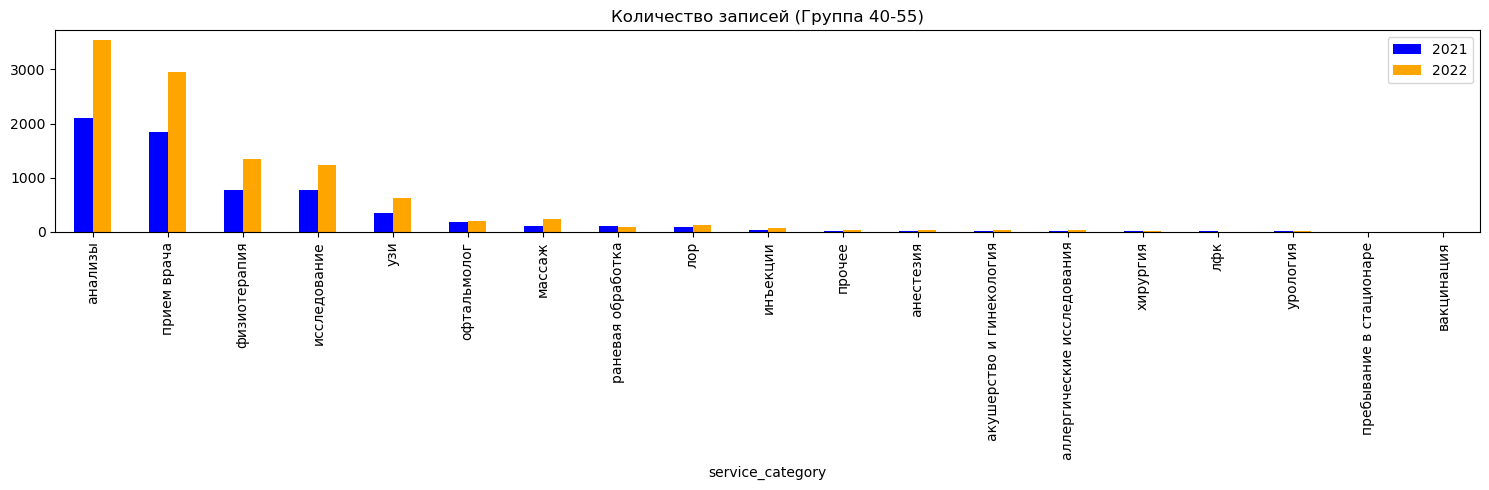

In [65]:
data_24_39 = data[(data['service_date'].dt.month <= 8) & (data['age_group'] == '24-39')]

grouped_data_24_39 = data_24_39.groupby(['year', 'service_category'])
result_24_39 = grouped_data_24_39.agg({
    'record_id': 'count'
}).reset_index()
pivot_result_24_39 = result_24_39.pivot_table(index='service_category', columns='year', values='record_id')
pivot_result_24_39.columns = ['2021', '2022']

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
pivot_result_24_39_sorted = pivot_result_24_39.sort_values(by='2021', ascending=False)
pivot_result_24_39_sorted.plot(kind='bar', ax=axes, color=['blue', 'orange'])
axes.set_title('Количество записей (Группа 24-39)')
plt.tight_layout()
plt.show()

data_40_55 = data[(data['service_date'].dt.month <= 8) & (data['age_group'] == '40-55')]

grouped_data_40_55 = data_40_55.groupby(['year', 'service_category'])
result_40_55 = grouped_data_40_55.agg({
    'record_id': 'count'
}).reset_index()
pivot_result_40_55 = result_40_55.pivot_table(index='service_category', columns='year', values='record_id')
pivot_result_40_55.columns = ['2021', '2022']

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
pivot_result_40_55_sorted = pivot_result_40_55.sort_values(by='2021', ascending=False)
pivot_result_40_55_sorted.plot(kind='bar', ax=axes, color=['blue', 'orange'])
axes.set_title('Количество записей (Группа 40-55)')
plt.tight_layout()
plt.show()


В процентах сильнее всего вырос объем записей у молодых пациентов с 18 до 23 лет, однако в абсолютах видно, что основной прирост принесли пациенты с 24 до 55 лет, являющиеся большинством. Внутри групп нет приростов или падений, которые не соответствовали бы общему тренду по категориям.

Посмотрим также на изменение цен в этих двух возрастных группах по категориям

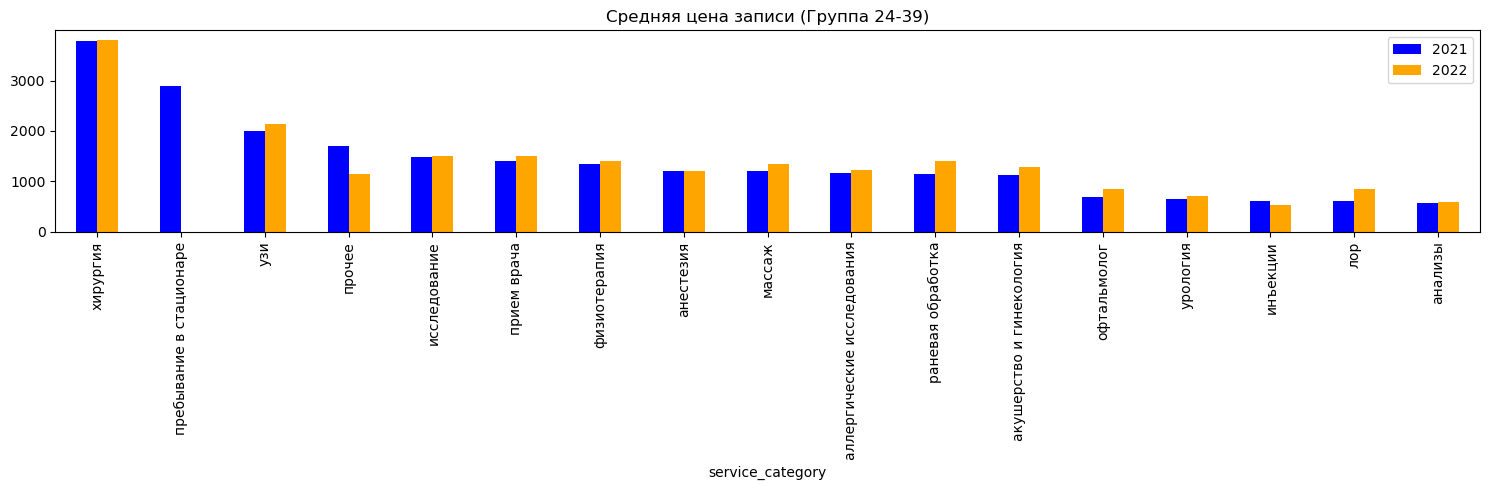

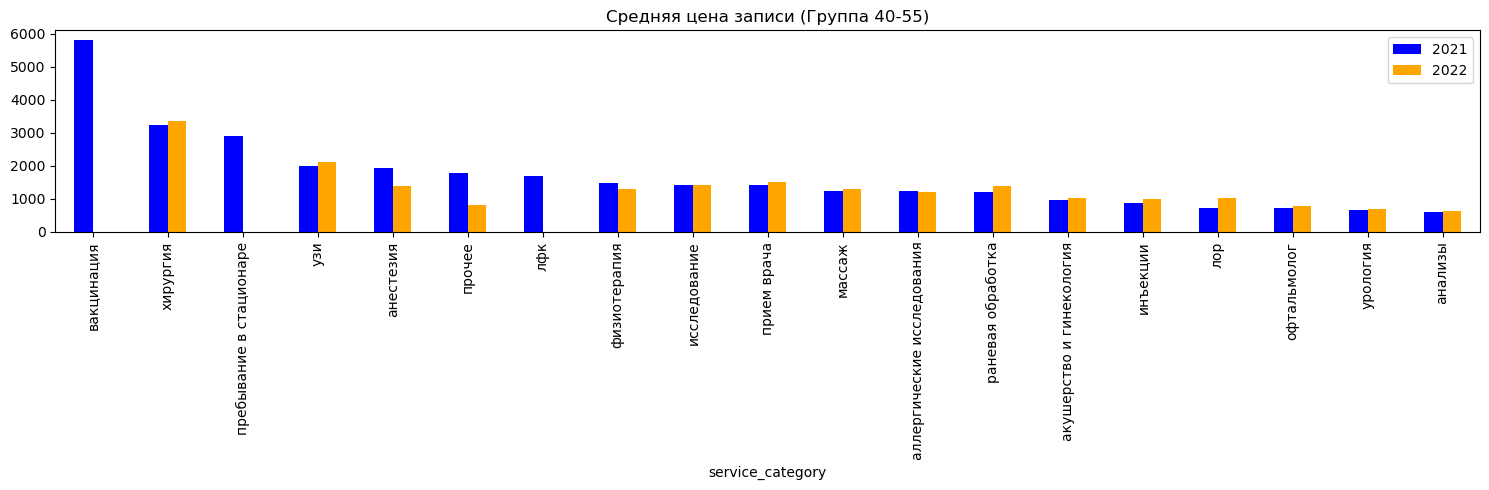

In [89]:
result_24_39_p = grouped_data_24_39.agg({
    'service_amount': 'mean'
}).reset_index()
pivot_result_24_39_p = result_24_39_p.pivot_table(index='service_category', columns='year', values='service_amount')
pivot_result_24_39_p.columns = ['2021', '2022']

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
pivot_result_24_39_p_sorted = pivot_result_24_39_p.sort_values(by='2021', ascending=False)
pivot_result_24_39_p_sorted.plot(kind='bar', ax=axes, color=['blue', 'orange'])
axes.set_title('Средняя цена записи (Группа 24-39)')
plt.tight_layout()
plt.show()

result_40_55_p = grouped_data_40_55.agg({
    'service_amount': 'mean'
}).reset_index()
pivot_result_40_55_p = result_40_55_p.pivot_table(index='service_category', columns='year', values='service_amount')
pivot_result_40_55_p.columns = ['2021', '2022']

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
pivot_result_40_55_p_sorted = pivot_result_40_55_p.sort_values(by='2021', ascending=False)
pivot_result_40_55_p_sorted.plot(kind='bar', ax=axes, color=['blue', 'orange'])
axes.set_title('Средняя цена записи (Группа 40-55)')
plt.tight_layout()
plt.show()


В 2022 году в пациенты обоих групп не обращались за стационарными услугами, а пациенты 40-55 лет также не занимались ЛФК. В остальном изменение цен по категориям внутри этих возрастных групп не показало аномалий и не отличается от распределения по категориям в целом.

Посмотрим на изменение объема записей по полу:

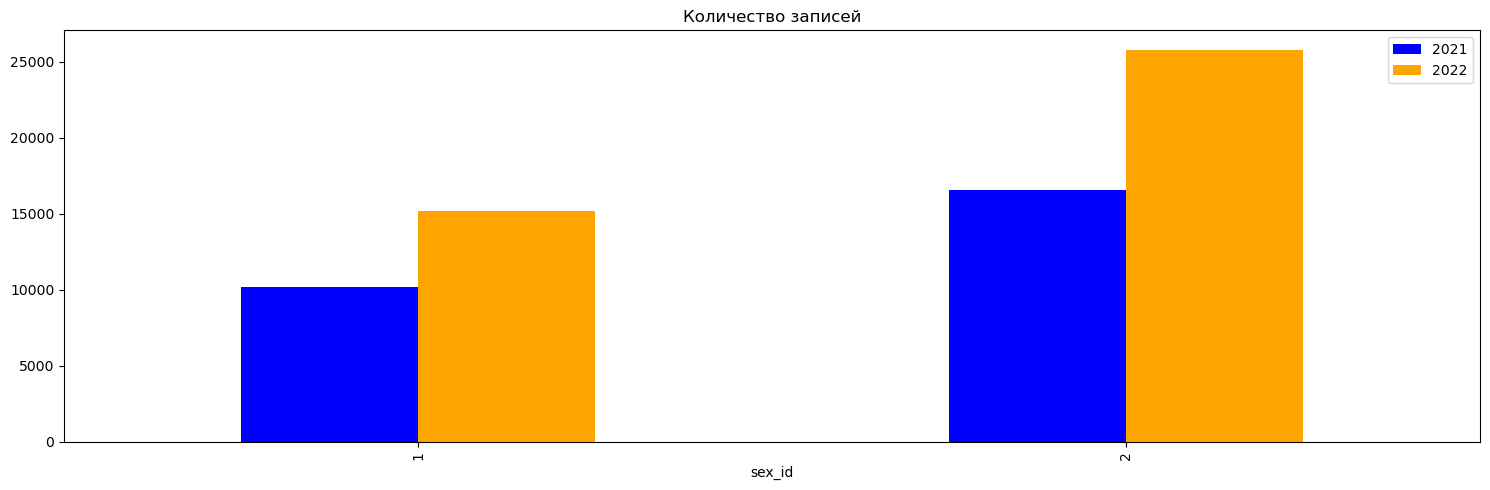

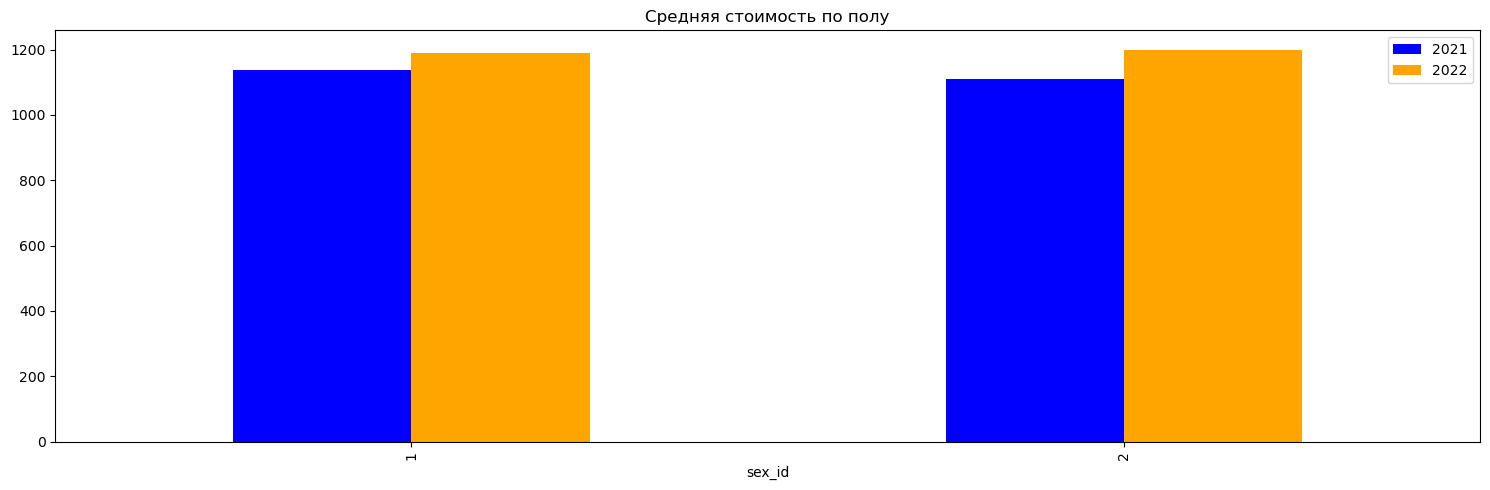

In [209]:
grouped_data_sex = equal_y_periods.groupby(['year', 'sex_id'])

result_sex = grouped_data_sex.agg({
    'insured': 'count'
}).reset_index()
pivot_result_sex = result_sex.pivot_table(index='sex_id', columns=['year'], values='insured')
pivot_result_sex.columns = ['2021', '2022']

fig, axes = plt.subplots(1, 1, figsize=(15, 5))

pivot_result_sex.plot(kind='bar', ax=axes, color=['blue', 'orange'])
axes.set_title('Количество записей')

plt.tight_layout()
plt.show()

result_sex_p = grouped_data_sex.agg({
    'service_amount': 'mean'
}).reset_index()
pivot_result_sex_p = result_sex_p.pivot_table(index='sex_id', columns=['year'], values='service_amount')
pivot_result_sex_p.columns = ['2021', '2022']

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
pivot_result_sex_p.plot(kind='bar', ax=axes, color=['blue', 'orange'])
axes.set_title('Средняя стоимость по полу')
plt.tight_layout()
plt.show()

Средняя цена приема для пола 1 выросла меньше, чем для пола 2.
Посмотрим на распределение по полу и категории услуг

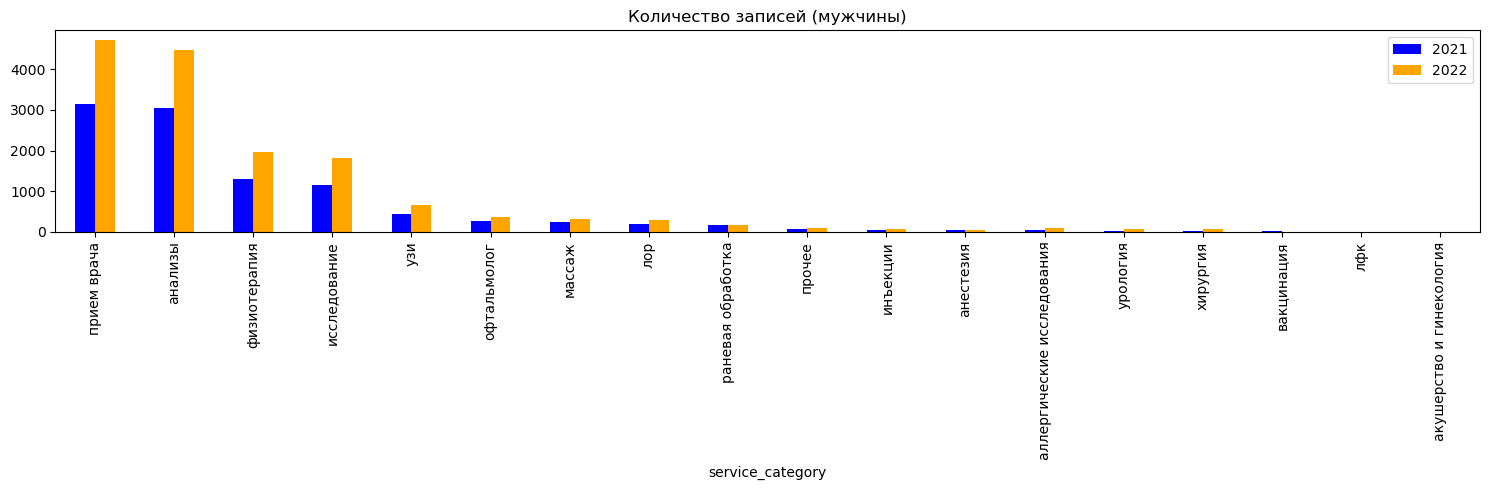

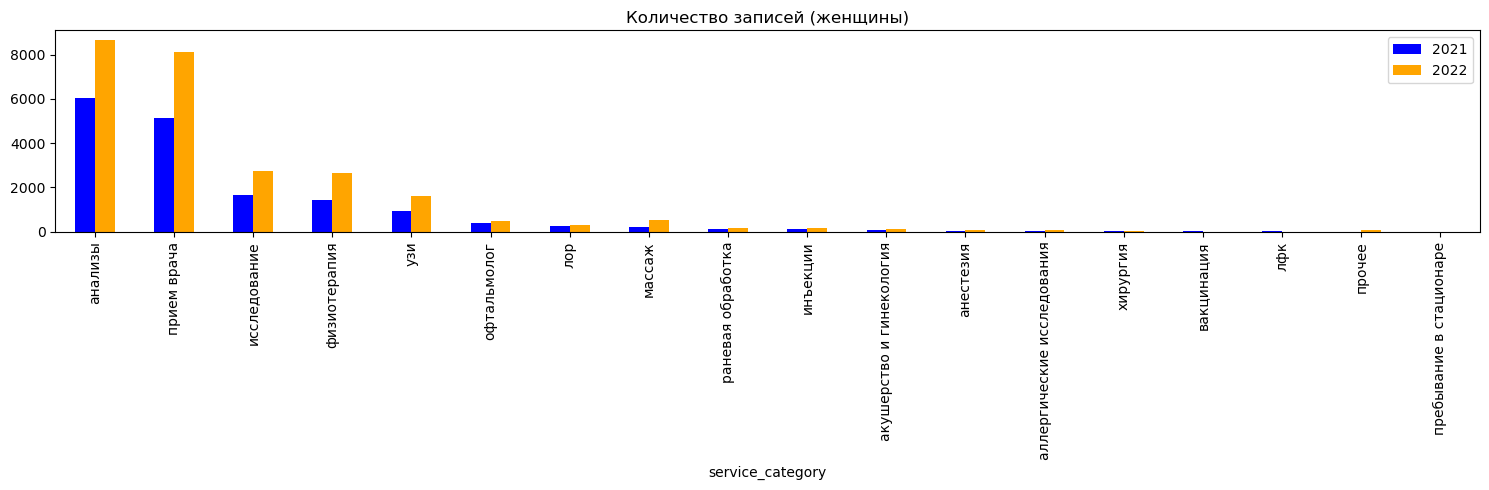

In [110]:
data_sex_1 = data[(data['service_date'].dt.month <= 8) & (data['sex_id'] == 1)]

grouped_data_sex_1 = data_sex_1.groupby(['year', 'service_category'])
result_sex_1 = grouped_data_sex_1.agg({
    'record_id': 'count'
}).reset_index()
pivot_result_sex_1 = result_sex_1.pivot_table(index='service_category', columns='year', values='record_id')
pivot_result_sex_1.columns = ['2021', '2022']

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
pivot_result_sex_1_sorted = pivot_result_sex_1.sort_values(by='2021', ascending=False)
pivot_result_sex_1_sorted.plot(kind='bar', ax=axes, color=['blue', 'orange'])
axes.set_title('Количество записей (мужчины)')
plt.tight_layout()
plt.show()

data_sex_2 = data[(data['service_date'].dt.month <= 8) & (data['sex_id'] == 2)]

grouped_data_sex_2 = data_sex_2.groupby(['year', 'service_category'])
result_sex_2 = grouped_data_sex_2.agg({
    'record_id': 'count'
}).reset_index()
pivot_result_sex_2 = result_sex_2.pivot_table(index='service_category', columns='year', values='record_id')
pivot_result_sex_2.columns = ['2021', '2022']

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
pivot_result_sex_2_sorted = pivot_result_sex_2.sort_values(by='2021', ascending=False)
pivot_result_sex_2_sorted.plot(kind='bar', ax=axes, color=['blue', 'orange'])
axes.set_title('Количество записей (женщины)')
plt.tight_layout()
plt.show()

Судя по большему объему услуг в категории акушерства и гинекологии на втором графике, sex_id = 1 - это женщины.
Распределение по категориям и по полу соответствует общим данным.

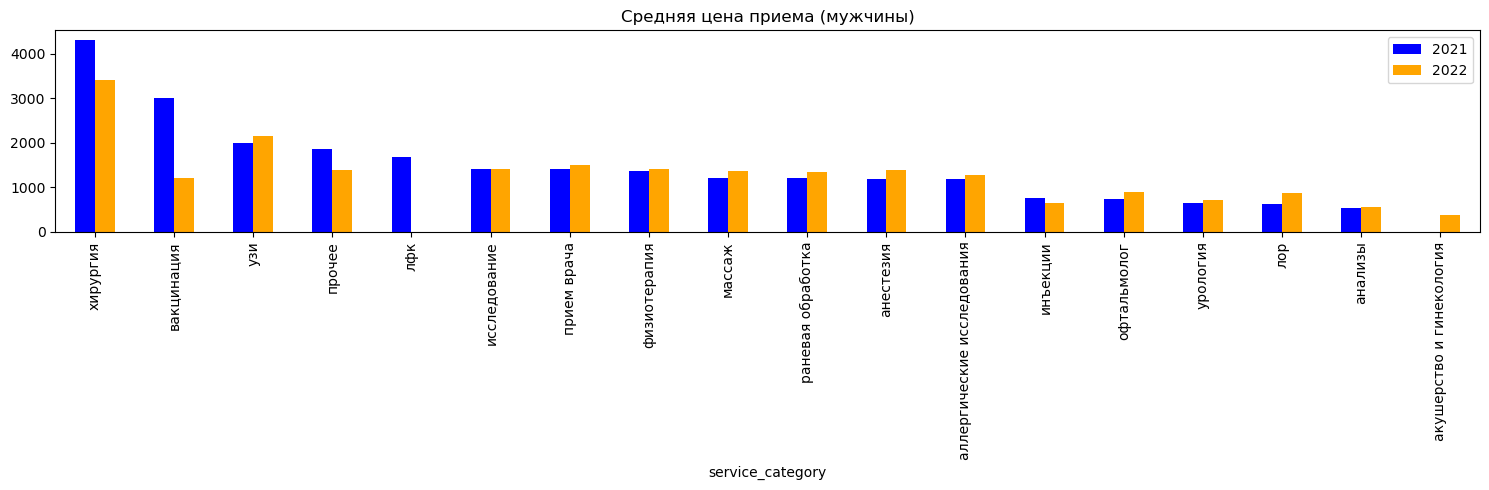

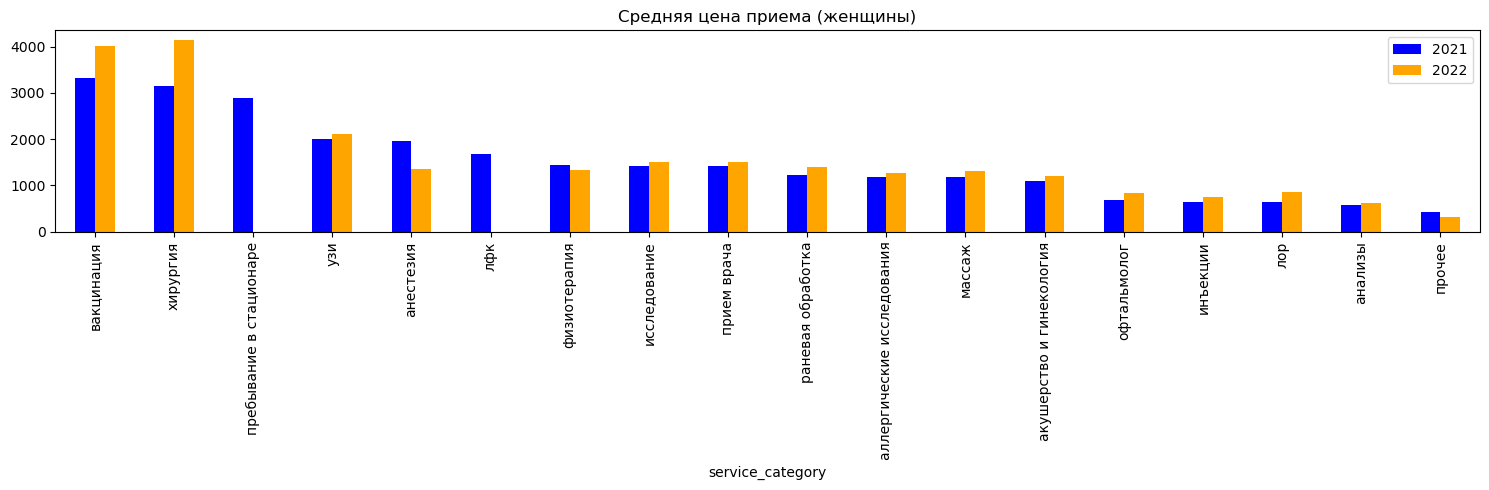

In [109]:
data_sex_1 = data[(data['service_date'].dt.month <= 8) & (data['sex_id'] == 1)]

grouped_data_sex_1 = data_sex_1.groupby(['year', 'service_category'])
result_sex_1 = grouped_data_sex_1.agg({
    'service_amount': 'mean'
}).reset_index()
pivot_result_sex_1 = result_sex_1.pivot_table(index='service_category', columns='year', values='service_amount')
pivot_result_sex_1.columns = ['2021', '2022']

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
pivot_result_sex_1_sorted = pivot_result_sex_1.sort_values(by='2021', ascending=False)
pivot_result_sex_1_sorted.plot(kind='bar', ax=axes, color=['blue', 'orange'])
axes.set_title('Средняя цена приема (мужчины)')
plt.tight_layout()
plt.show()

data_sex_2 = data[(data['service_date'].dt.month <= 8) & (data['sex_id'] == 2)]

grouped_data_sex_2 = data_sex_2.groupby(['year', 'service_category'])
result_sex_2 = grouped_data_sex_2.agg({
    'service_amount': 'mean'
}).reset_index()
pivot_result_sex_2 = result_sex_2.pivot_table(index='service_category', columns='year', values='service_amount')
pivot_result_sex_2.columns = ['2021', '2022']

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
pivot_result_sex_2_sorted = pivot_result_sex_2.sort_values(by='2021', ascending=False)
pivot_result_sex_2_sorted.plot(kind='bar', ax=axes, color=['blue', 'orange'])
axes.set_title('Средняя цена приема (женщины)')
plt.tight_layout()
plt.show()

Средняя цена приема для мужчин выросла меньше за счет значительного снижения в двух категориях с самой высокой ценой - хирургии и вакцинации.
При этом для женщих стоимость услуг в этих же категориях выросла, по остальным категориям изменение цен было схожим.

Посмотрим на список услуг в этих двух категориях отдельно для мужчин и женщин.

In [185]:
#напишем функцию, чтобы сократить количество кода
def generate_result_table(sex_id, service_category):
    filtered_data = data[(data['sex_id'] == sex_id) & (data['service_category'] == service_category)]

    result_table = filtered_data.groupby(['service_name', 'year']).agg({
        'service_amount': 'mean',
        'record_id': 'count'
    }).rename(columns={'record_id': 'count'}).unstack()

    result_table = result_table.reset_index().fillna(0)
    result_table.columns = ['service_name', f'Цена {2021}', f'Цена {2022}', f'Количество {2021}', f'Количество {2022}']
    result_table[f'Цена {2021}'] = round(result_table[f'Цена {2021}'], 2)
    result_table[f'Цена {2022}'] = round(result_table[f'Цена {2022}'], 2)
    result_table[f'Количество {2021}'] = result_table[f'Количество {2021}'].astype(int)
    result_table[f'Количество {2022}'] = result_table[f'Количество {2022}'].astype(int)
    result_table['Изменение цены'] = round(result_table[f'Цена {2022}'] - result_table[f'Цена {2021}'], 2)

    return result_table


sex_id_example = 1
service_category_example = 'хирургия'
result_table_example = generate_result_table(sex_id_example, service_category_example)
print('Изменение услуг в категории "Хирургия" для мужчин')
result_table_example

Изменение услуг в категории "Хирургия" для мужчин


,service_name,Цена 2021,Цена 2022,Количество 2021,Количество 2022,Изменение цены
0,вскрытие абсцедирующего фурункула,4910.75,5090.00,4,1,179.25
1,вскрытие гидраденита (за один очаг),3150.00,0.00,1,0,-3150.00
2,вскрытие карбункула,6620.00,0.00,1,0,-6620.00
3,вскрытие кисты небной миндалины,1638.00,0.00,1,0,-1638.00
4,вскрытие панариция,7665.00,8050.00,1,1,385.00
5,вскрытие паранихия,3213.00,3370.00,2,1,157.00
6,"вскрытие фурункула (лор орг,)",0.00,3200.00,0,1,3200.00
7,"криодеструкция папиллом, кондилом, бородавок (...",0.00,760.00,0,1,760.00
8,лечебная пункция сустава с внутрисуставным вве...,1522.50,1540.00,4,5,17.50
9,лечебно-диагностическая пункция коленного суст...,3890.00,3900.00,1,11,10.00


Ни одна услуга в категории на самом деле не подешевела, но на средние значения повлияло снижение объема более дорогих услуг и повышение более дешевых: например, в 2022 году пациентам 6 раз оказывали услугу "удаление инородного тела конъюнктивы", которой никто не пользовался в 2021 году, но при этом в 2022 году не проводились удаление вросшего ногтя и вскрытие карбункула стоимостью более 6 тысяч рублей.

In [186]:
sex_id_example = 1
service_category_example = 'вакцинация'
result_table_example = generate_result_table(sex_id_example, service_category_example)
print('Изменение услуг в категории "Вакцинация" для мужчин')
result_table_example

Изменение услуг в категории "Вакцинация" для мужчин


,service_name,Цена 2021,Цена 2022,Количество 2021,Количество 2022,Изменение цены
0,"вакцинация вакциной ""опв""",714.0,0.0,1,0,-714.0
1,"вакцинация вакциной ""пентаксим""",4652.0,0.0,3,0,-4652.0
2,"вакцинация вакциной ""пероральная полио вакцина...",714.0,0.0,2,0,-714.0
3,"вакцинация вакциной ""полимилекс""",2100.0,0.0,1,0,-2100.0
4,"вакцинация вакциной ""превенар""",5807.0,0.0,2,0,-5807.0
5,"вакцинация вакциной ""ультрикс квадри""",0.0,1210.0,0,1,1210.0
6,"вакцинация вакциной mmr ii (от кори, краснухи,...",1680.0,0.0,2,0,-1680.0


С вакцинацией та же ситуация: в 2022 году была проведена всего 1 вакцинация по более низкой цене в сравнении с вакцинами, применявшимися в 2021 году.

In [189]:
sex_id_example = 2
service_category_example = 'хирургия'
result_table_example = generate_result_table(sex_id_example, service_category_example)
print('Изменение услуг в категории "Хирургия" для женщин')
result_table_example

Изменение услуг в категории "Хирургия" для женщин


,service_name,Цена 2021,Цена 2022,Количество 2021,Количество 2022,Изменение цены
0,вскрытие абсцедирующего фурункула,4851.00,6312.00,3,5,1461.00
1,вскрытие карбункула,0.00,6620.00,0,1,6620.00
2,вскрытие панариция,7665.00,8166.67,1,3,501.67
3,вскрытие паранихия,0.00,3370.00,0,1,3370.00
4,"вскрытие фурункула (лор орг,)",3045.00,0.00,1,0,-3045.00
5,"криодеструкция папиллом, кондилом, бородавок (...",725.00,0.00,1,0,-725.00
6,лечебная пункция сустава с внутрисуставным вве...,1470.00,1540.00,5,1,70.00
7,лечебно-диагностическая пункция коленного суст...,0.00,4940.00,0,1,4940.00
8,обработка глаза после хирургических манипуляций,0.00,680.00,0,2,680.00
9,пункция с введением лекарственного средства (б...,2987.92,2898.00,12,5,-89.92


In [188]:
sex_id_example = 2
service_category_example = 'вакцинация'
result_table_example = generate_result_table(sex_id_example, service_category_example)
print('Изменение услуг в категории "Вакцинация" для женщин')
result_table_example

Изменение услуг в категории "Вакцинация" для женщин


,service_name,Цена 2021,Цена 2022,Количество 2021,Количество 2022,Изменение цены
0,"вакцинация вакциной ""варилрикс""",0.0,4600.0,0,1,4600.0
1,"вакцинация вакциной ""менактра""",0.0,9000.0,0,1,9000.0
2,"вакцинация вакциной ""пентаксим""",4728.0,0.0,3,0,-4728.0
3,"вакцинация вакциной ""полимилекс""",2100.0,0.0,1,0,-2100.0
4,"вакцинация вакциной ""превенар""",5807.0,0.0,3,0,-5807.0
5,"вакцинация вакциной ""ультрикс квадри""",0.0,1210.0,0,2,1210.0
6,"вакцинация вакциной ""эувакс""",966.0,0.0,2,0,-966.0
7,"вакцинация вакциной mmr ii (от кори, краснухи,...",1680.0,0.0,4,0,-1680.0


Для женщин же в обеих категориях ситуация обратная: перечень услуг, использованных в 2022 году, изменился в сторону более дорогих - например, хирургическое удаление доброкачественной опухоли и вакцинация вакциной "менактра" 

Вероятно, такие же изменения перечня конкретных услуг могут происходить и в других, более крупных категориях, но за счет сглаживания на большем объеме данных эти изменения не так заметны на уровне категорий.

Различия в цене в детальных срезах (пол + категория) видно только в категориях с небольшим объемом услуг, где каждое изменение сильнее влияет на среднее. В целом нельзя сказать, что портрет пользователей изменился - записей стало больше от пользователей всех возрастов и обоих полов, цена выросла на всех срезах, кроме нескольких небольших. **Гипотеза опровергнута**

## Выводы

В ходе исследования мы очистили и подготовили данные. Были добавлены две колонки: с категорией услуги на основе словарного распределения услуг и с категорией возраста на основе разделения пациентов на пять возрастных групп.

Так как данные за 2022 год заканчиваются в августе, мы сравнивали периоды с января по август каждого года, чтобы уравнять периоды.
Изучив показатели общей выручки, средней и медианной оплаты, мы получили следующие данные:

Изменение суммы выручки, %: 63.52 </br>
Изменение медианы оплаты, %: 9.89</br>
Изменение средней оплаты, %: 6.69</br>

По информации Росстата, инфляция в категории "консультационный прием врача" за этот же период составила 10,42%. Не имея данных о инфляции в других категориях медицинских услуг и о городе или городах нахождения клиники, мы использовали этот показатель для сравнения.

Отдельно мы выяснили, что количество обращений в 2022 году выросло на 53%, что можно считать положительной тенденцией.

**Таким образом первый вывод, который мы получили - изменение цен клиники связано с инфляцией, средняя оплата выросла меньше уровня инфляции, что говорит об адекватном и, возможно, даже заниженном уровне цен.**

Далее были выдвинуты гипотезы, что могло повлиять на рост цен дополнительно, не считая инфляцию:
1. Изменение состава услуг
2. Изменение портрета пользователей

В ходе исследования не было выявлено ни первого, ни второго, поэтому **обе гипотезы были опровергнуты.** 

Нельзя отметить какой-то отдельный драйвер, кроме инфляции, который привел бы к росту цен.

В целом, скорее можно говорить не о росте цен клиники, а о недостаточном росте вслед за инфляцией - такая ситуация может привести к снижению прибыли.
**Рекомендуется пересмотреть цены в соответствии со средним показателем роста в индустрии.**